# 06 자전거 대여 수요 예측
* 미션
    * [자전거 대여 수량 예측](https://www.kaggle.com/c/bike-sharing-demand)
* 평가지표
    * RMSLE
    * ![](../images/bike_metrix.PNG)
        * $n$ is ther number of hours in the test set
        * $p_i$ is your  predicted count
        * $a_i$ is the actual count
        * $log(x)$ is the natural logarithm

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
data_path = '../data/06_bike/'

In [18]:
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path+'test.csv')
submission_df = pd.read_csv(data_path+'sampleSubmission.csv')

In [19]:
train = train_df.copy()

In [20]:
# 데이터 합치기
all_data = pd.concat([train, test_df], ignore_index=True)
all_data.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN
17378,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN


In [21]:
# 파생 피처 추가
all_data['datetime'] = pd.to_datetime(all_data['datetime'])

all_data['year'] = all_data['datetime'].dt.year
all_data['month'] = all_data['datetime'].dt.month
all_data['day'] = all_data['datetime'].dt.day
all_data['hour'] = all_data['datetime'].dt.hour
all_data['weekday'] = all_data['datetime'].dt.weekday

In [22]:
# 피처 제거
removal_feature = ['casual', 'registered', 'datetime', 'month', 'day', 'windspeed']
all_data = all_data.drop(columns=removal_feature)

In [23]:
# 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]
y = X_train['count']
log_y = np.log(y)
X_train = X_train.drop(columns=['count'])
X_test = X_test.drop(columns=['count'])

X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,0,5
1,1,0,0,1,9.02,13.635,80,2011,1,5
2,1,0,0,1,9.02,13.635,80,2011,2,5
3,1,0,0,1,9.84,14.395,75,2011,3,5
4,1,0,0,1,9.84,14.395,75,2011,4,5


## 6.7 성능 개선 III : 랜덤 포레스트 회귀 모델
### 랜덤 포레스트
* 훈련 데이터를 랜덤하게 샘플링한 모델 n개를 각각 훈련하여 나온 결과를 평균을 계산함

In [24]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    return np.sqrt(np.mean((log_true-log_pred)**2))

In [25]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 모델 생성
randomforest_model = RandomForestRegressor(oob_score=True)
# 그리드서치 객체 생성
rf_params = {
    'random_state': [42],
    'n_estimators': [70, 100, 120, 140],
}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
gridsearch_random_forest_model = GridSearchCV(
    estimator=randomforest_model,
    param_grid=rf_params,
    scoring=rmsle_scorer,
    cv=5
)
gridsearch_random_forest_model.fit(X_train, log_y)
print(f'best hyperparameter : {gridsearch_random_forest_model.best_params_}, oob score : {gridsearch_random_forest_model.best_estimator_.oob_score_}')

best hyperparameter : {'n_estimators': 140, 'random_state': 42}, oob score : 0.948510065173127


In [26]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)
# 평가
print(f'random forest RMSLE : {rmsle(log_y, preds, True):.4f}')

random forest RMSLE : 0.1123


Text(0.5, 1.0, 'Predicted Test Data Distribution')

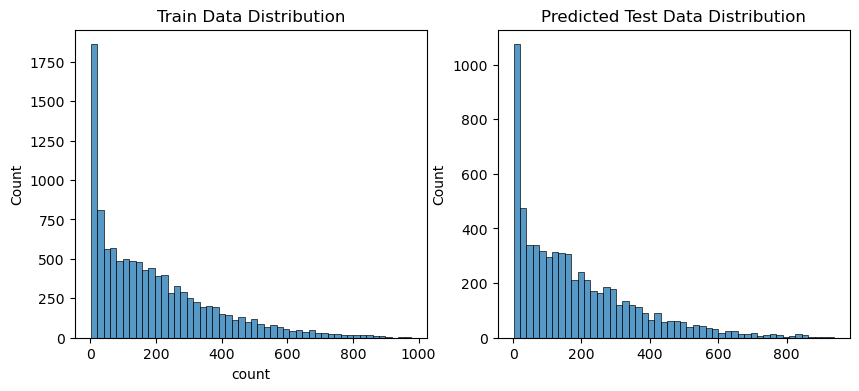

In [27]:
# 결과 확인
randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution')

In [28]:
# 제출
submission_df['count'] = np.exp(randomforest_preds)
# submission_df.to_csv('submission.csv', index=False)

## 학습 마무리
### 핵심 요약
* 캐글 경진대회 프로세스
    * 경진대회 이해 -> 탐색적 데이터 분석 -> 베이스라인 모델 -> 성능 개선
* 회귀 모델의 경우 타깃값이 정규분포에 가까울수록 회귀 모델의 성능이 좋음
    * 한쪽으로 치우친 타깃값은 log <-> exp 함수를 통해 변환과 복원하여 사용
* 훈련 데이터의 이상치를 제거하면 일반화 성능이 좋아짐
* 기존 피처를 분해/조합하여 모델링에 도움되는 새로운 피처 추가
* 불필요한 피처는 제거
* 선형 회귀, 릿지, 라쏘 모델은 회귀 문제를 대표적인 모델
    * 최상의 성능을 기대하기는 어려움
* 랜덤 포레스트 회귀
    * 여러 모델을 묶어 더 나은 성능을 이끌어냄
* 그리드서치
    * 교차 검증으로 최적의 하이퍼파라미터 값을 찾아주는 기법

In [29]:
# season -> month
train = train_df.copy()
# 이상치 제거
train = train[train['weather'] != 4]
# 데이터 합치기
all_data = pd.concat([train, test_df], ignore_index=True)
# 파생 피처 추가
all_data['datetime'] = pd.to_datetime(all_data['datetime'])

all_data['year'] = all_data['datetime'].dt.year
all_data['month'] = all_data['datetime'].dt.month
all_data['day'] = all_data['datetime'].dt.day
all_data['hour'] = all_data['datetime'].dt.hour
all_data['weekday'] = all_data['datetime'].dt.weekday

# 피처 제거
removal_feature = ['casual', 'registered', 'datetime', 'season', 'day', 'windspeed'] # month -> season
all_data = all_data.drop(columns=removal_feature)

# 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]
y = X_train['count']
X_train = X_train.drop(columns=['count'])
X_test = X_test.drop(columns=['count'])

# log
log_y = np.log(y)

# 모델 생성
randomforest_season_model = RandomForestRegressor(oob_score=True)
# 그리드서치 객체 생성
rf_params = {
    'random_state': [42],
    'n_estimators': [70, 100, 120, 140],
}
gridsearch_random_forest_season_model = GridSearchCV(
    estimator=randomforest_season_model,
    param_grid=rf_params,
    scoring=rmsle_scorer,
    cv=5
)
gridsearch_random_forest_season_model.fit(X_train, log_y)
print(f'best hyperparameter : {gridsearch_random_forest_model.best_params_}, oob score : {gridsearch_random_forest_model.best_estimator_.oob_score_}')

# 예측
preds = gridsearch_random_forest_season_model.best_estimator_.predict(X_train)
# 평가
print(f'random forest RMSLE : {rmsle(log_y, preds, True):.4f}')
# 결과 확인
randomforest_season_preds = gridsearch_random_forest_season_model.best_estimator_.predict(X_test)
# 제출
submission_df['count'] = np.exp(randomforest_season_preds)
# submission_df.to_csv('submission.csv', index=False)

best hyperparameter : {'n_estimators': 140, 'random_state': 42}, oob score : 0.948510065173127
random forest RMSLE : 0.1089


Text(0.5, 1.0, 'Predicted Test Data Distribution For Month')

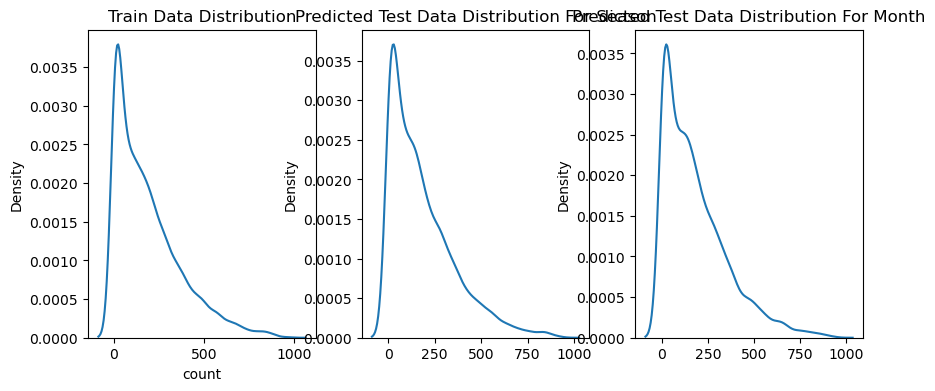

In [30]:
# 결과 확인
figure, axes = plt.subplots(ncols=3)
figure.set_size_inches(10, 4)

sns.kdeplot(y, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.kdeplot(np.exp(randomforest_preds), ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution For Season')
sns.kdeplot(np.exp(randomforest_season_preds), ax=axes[2])
axes[2].set_title('Predicted Test Data Distribution For Month')